# 06 - Generalização em Machine Learning

Neste notebook, vamos explorar um dos conceitos mais importantes em machine learning: **generalização**. Veremos como os modelos se comportam quando expostos a dados que não viram durante o treinamento e como evitar problemas como overfitting e underfitting.

## Objetivos de Aprendizagem

Ao final deste notebook, você será capaz de:
- Compreender os conceitos de overfitting, underfitting e bias-variance tradeoff
- Implementar modelos polinomiais usando PyTorch para demonstrar estes conceitos
- Analisar curvas de treinamento para identificar problemas de generalização
- Aplicar técnicas de validação em datasets reais (Fashion-MNIST)

## Importações

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuração para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

Dispositivo utilizado: cpu


## 1. Conceitos Fundamentais de Generalização

### 1.1 Definições

**Generalização** é a capacidade de um modelo de fazer predições precisas em dados que não foram vistos durante o treinamento.

**Overfitting (Sobreajuste)**: O modelo aprende os dados de treinamento muito bem, incluindo ruído e detalhes específicos, mas falha em generalizar para novos dados.

**Underfitting (Subajuste)**: O modelo é muito simples para capturar os padrões subjacentes nos dados, resultando em performance ruim tanto no treinamento quanto na validação.

### 1.2 Bias-Variance Tradeoff

O erro total de um modelo pode ser decomposto em três componentes:

$$\text{Erro Total} = \text{Bias}^2 + \text{Variância} + \text{Ruído}$$

- **Bias**: Erro devido a suposições simplificadas no algoritmo de aprendizagem
- **Variância**: Erro devido à sensibilidade a pequenas flutuações no conjunto de treinamento
- **Ruído**: Erro irredutível nos dados

![Bias-Variance Tradeoff](https://upload.wikimedia.org/wikipedia/commons/9/9f/Bias_and_variance_contributing_to_total_error.svg)

## 2. Demonstração com Regressão Polinomial

Vamos criar um exemplo prático usando regressão polinomial para demonstrar overfitting e underfitting.

### 2.1 Classe Polinomial Customizada

In [ ]:
class PolynomialRegressor(nn.Module):
    """Modelo de regressão polinomial usando PyTorch.

    Implementa um polinômio de grau n:
    y = a_0 + a_1*x + a_2*x^2 + ... + a_n*x^n
    """

    def __init__(self, degree):
        super(PolynomialRegressor, self).__init__()
        self.degree = degree
        # Coeficientes do polinômio (parâmetros aprendíveis)
        self.coefficients = nn.Parameter(torch.randn(degree + 1))

    def forward(self, x):
        """Forward pass: calcula o polinômio para os valores de entrada."""
        # Criar matriz de potências [1, x, x^2, x^3, ..., x^n]
        powers = torch.stack([x.squeeze()**i for i in range(self.degree + 1)], dim=1)
        # Calcular y = sum(a_i * x^i)
        return torch.sum(powers * self.coefficients, dim=1, keepdim=True)

    def get_coefficients(self):
        """Retorna os coeficientes aprendidos."""
        return self.coefficients.detach().numpy()

# Testar a classe
model = PolynomialRegressor(degree=2)
x_test = torch.linspace(-2, 2, 10).unsqueeze(1)
y_test = model(x_test)
print(f'Forma da entrada: {x_test.shape}')
print(f'Forma da saída: {y_test.shape}')
print(f'Coeficientes iniciais: {model.get_coefficients()}')

Forma da entrada: torch.Size([10, 1])
Forma da saída: torch.Size([10, 1])
Coeficientes iniciais: [ 0.40289024  1.159303   -0.02989531]


### 2.2 Geração de Dados Sintéticos

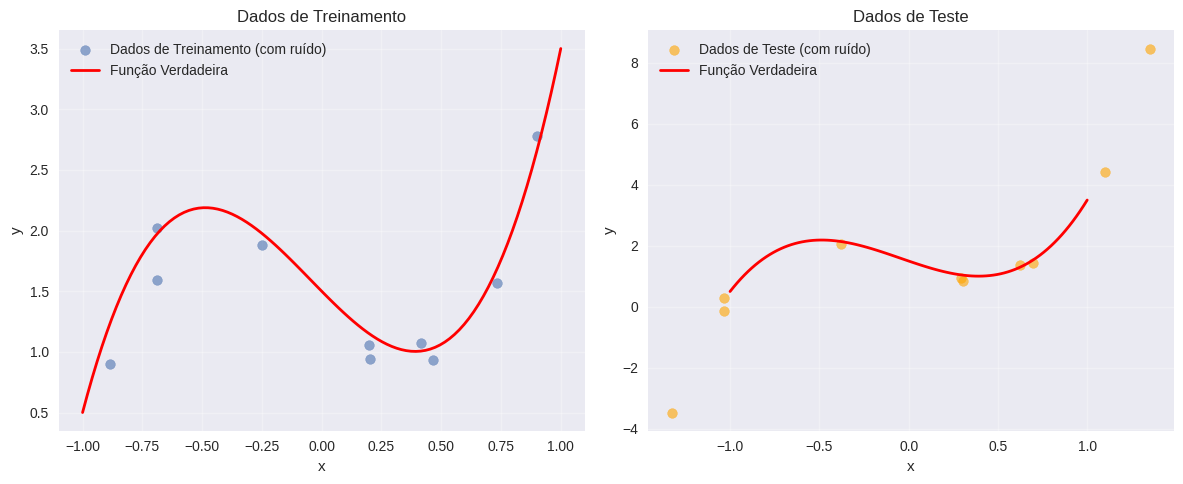

Tamanho do conjunto de treinamento: 10
Tamanho do conjunto de teste: 10


In [ ]:
def generate_data(true_func, n_samples=100, noise_std=0.3, x_range=(-2, 2), seed=42, offset=0.0):
    """Gera dados com base em uma função verdadeira e adiciona ruído."""
    np.random.seed(seed)

    x = np.random.uniform(x_range[0]-offset, x_range[1]+offset, n_samples)
    y_true = true_func(x)
    noise = np.random.normal(0, noise_std, n_samples)
    y_noisy = y_true + noise

    return x, y_true, y_noisy

# Definir função verdadeira (parábola)
def true_polynomial(x):
    return 1.5 - 2.0 * x + 0.5 * x**2 + 3.5 * x**3

x_range = (-1, 1)
noise_std = 0.2
test_offset = 0.5

# Gerar dados
x_train, y_train_true, y_train_noisy = generate_data(true_polynomial, n_samples=10, noise_std=noise_std, x_range=x_range)
x_test, y_test_true, y_test_noisy = generate_data(true_polynomial, n_samples=10, noise_std=noise_std, x_range=x_range, offset=test_offset)

# Converter para tensores
x_train_tensor = torch.FloatTensor(x_train).unsqueeze(1)
y_train_tensor = torch.FloatTensor(y_train_noisy).unsqueeze(1)
x_test_tensor = torch.FloatTensor(x_test).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test_noisy).unsqueeze(1)

# Visualizar os dados
plt.figure(figsize=(12, 5))

x_smooth = np.linspace(x_range[0], x_range[1], 100)
y_smooth = true_polynomial(x_smooth)

plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train_noisy, alpha=0.6, label='Dados de Treinamento (com ruído)')
plt.plot(x_smooth, y_smooth, 'r-', label='Função Verdadeira', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dados de Treinamento')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(x_test, y_test_noisy, alpha=0.6, color='orange', label='Dados de Teste (com ruído)')
plt.plot(x_smooth, y_smooth, 'r-', label='Função Verdadeira', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dados de Teste')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Tamanho do conjunto de treinamento: {len(x_train)}')
print(f'Tamanho do conjunto de teste: {len(x_test)}')

### 2.3 Função de Treinamento

Época 200/1000, Loss Treino: 0.0140, Loss Teste: 0.0835
Época 400/1000, Loss Treino: 0.0140, Loss Teste: 0.1035
Época 600/1000, Loss Treino: 0.0140, Loss Teste: 0.1035
Época 800/1000, Loss Treino: 0.0140, Loss Teste: 0.1035
Época 1000/1000, Loss Treino: 0.0140, Loss Teste: 0.1035

Coeficientes finais: [ 1.4131566  -2.057705    0.44587052  3.8533905 ]
Coeficientes verdadeiros: [1.5, -2.0, 0.5]


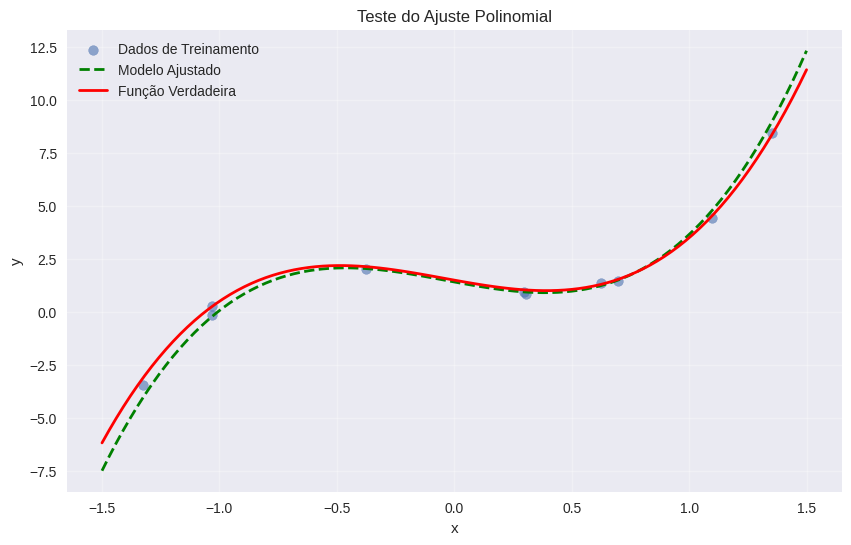

In [ ]:
def train_polynomial_model(degree, epochs=1000, lr=0.01, verbose=False):
    """Treina um modelo polinomial e retorna histórico de losses."""
    model = PolynomialRegressor(degree)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        optimizer.zero_grad()
        train_pred = model(x_train_tensor)
        train_loss = criterion(train_pred, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Avaliação
        model.eval()
        with torch.no_grad():
            test_pred = model(x_test_tensor)
            test_loss = criterion(test_pred, y_test_tensor)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if verbose and (epoch + 1) % 200 == 0:
            print(f'Época {epoch+1}/{epochs}, '
                  f'Loss Treino: {train_loss:.4f}, '
                  f'Loss Teste: {test_loss:.4f}')

    return model, train_losses, test_losses

# Testar a função de treinamento
model_test, train_losses_test, test_losses_test = train_polynomial_model(degree=3, epochs=1000, lr=0.1, verbose=True)
print(f'\nCoeficientes finais: {model_test.get_coefficients()}')
print(f'Coeficientes verdadeiros: [1.5, -2.0, 0.5]')

# Visualizar ajuste
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test_noisy, alpha=0.6, label='Dados de Treinamento')
x_plot = torch.linspace(x_range[0]-test_offset, x_range[1]+test_offset, 100).unsqueeze(1)
with torch.no_grad():
    y_plot = model_test(x_plot)
plt.plot(x_plot.squeeze(), y_plot.squeeze(), 'g--', linewidth=2, label='Modelo Ajustado')
plt.plot(x_plot.squeeze(), true_polynomial(x_plot.squeeze()), 'r-', linewidth=2, label='Função Verdadeira')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Teste do Ajuste Polinomial')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2.4 Comparação de Diferentes Graus de Complexidade

Agora vamos treinar modelos com diferentes graus polinomiais para demonstrar underfitting, bom ajuste e overfitting.

In [ ]:
# Treinar modelos com diferentes graus
degrees = [1, 2, 3, 5, 8]
models = {}
histories = {}

print("Treinando modelos com diferentes graus...")
for degree in tqdm(degrees):
    model, train_losses, test_losses = train_polynomial_model(degree, epochs=5000, lr=0.01)
    models[degree] = model
    histories[degree] = {'train': train_losses, 'test': test_losses}

print("Treinamento concluído!")

Treinando modelos com diferentes graus...


100%|██████████| 5/5 [00:34<00:00,  6.81s/it]

Treinamento concluído!


In [ ]:
import pandas as pd

results = []
for degree in degrees:
    train_mse = histories[degree]['train'][-1]
    test_mse = histories[degree]['test'][-1]
    gap = test_mse - train_mse

    results.append({
        'Grau': degree,
        'MSE Treino': f'{train_mse:.4f}',
        'MSE Teste': f'{test_mse:.4f}',
        'Gap': f'{gap:.4f}'
    })

df_results = pd.DataFrame(results)
print("=== ANÁLISE COMPARATIVA DOS MODELOS ===")
print(df_results.to_string(index=False))

# Visualizar coeficientes aprendidos
print("\n=== COEFICIENTES APRENDIDOS ===")
for degree in degrees:
    coeffs = models[degree].get_coefficients()
    print(f"Grau {degree}: {coeffs[:min(len(coeffs), 6)]}")

=== ANÁLISE COMPARATIVA DOS MODELOS ===
 Grau MSE Treino MSE Teste    Gap
    1     0.3330    8.0395 7.7065
    2     0.2501    7.5958 7.3457
    3     0.0140    0.1035 0.0895
    5     0.0133    1.9631 1.9498
    8     0.0131    3.8289 3.8159

=== COEFICIENTES APRENDIDOS ===
Grau 1: [1.4675269 0.1626022]
Grau 2: [1.0930376  0.21707956 1.0318685 ]
Grau 3: [ 1.4131548  -2.0577013   0.44587386  3.8533847 ]
Grau 5: [ 1.3795917 -1.7967424  0.5828954  2.628297  -0.1477     1.1738214]
Grau 8: [ 1.3919923  -1.8515903   0.50778437  2.9730034   0.00699937  0.5364359 ]


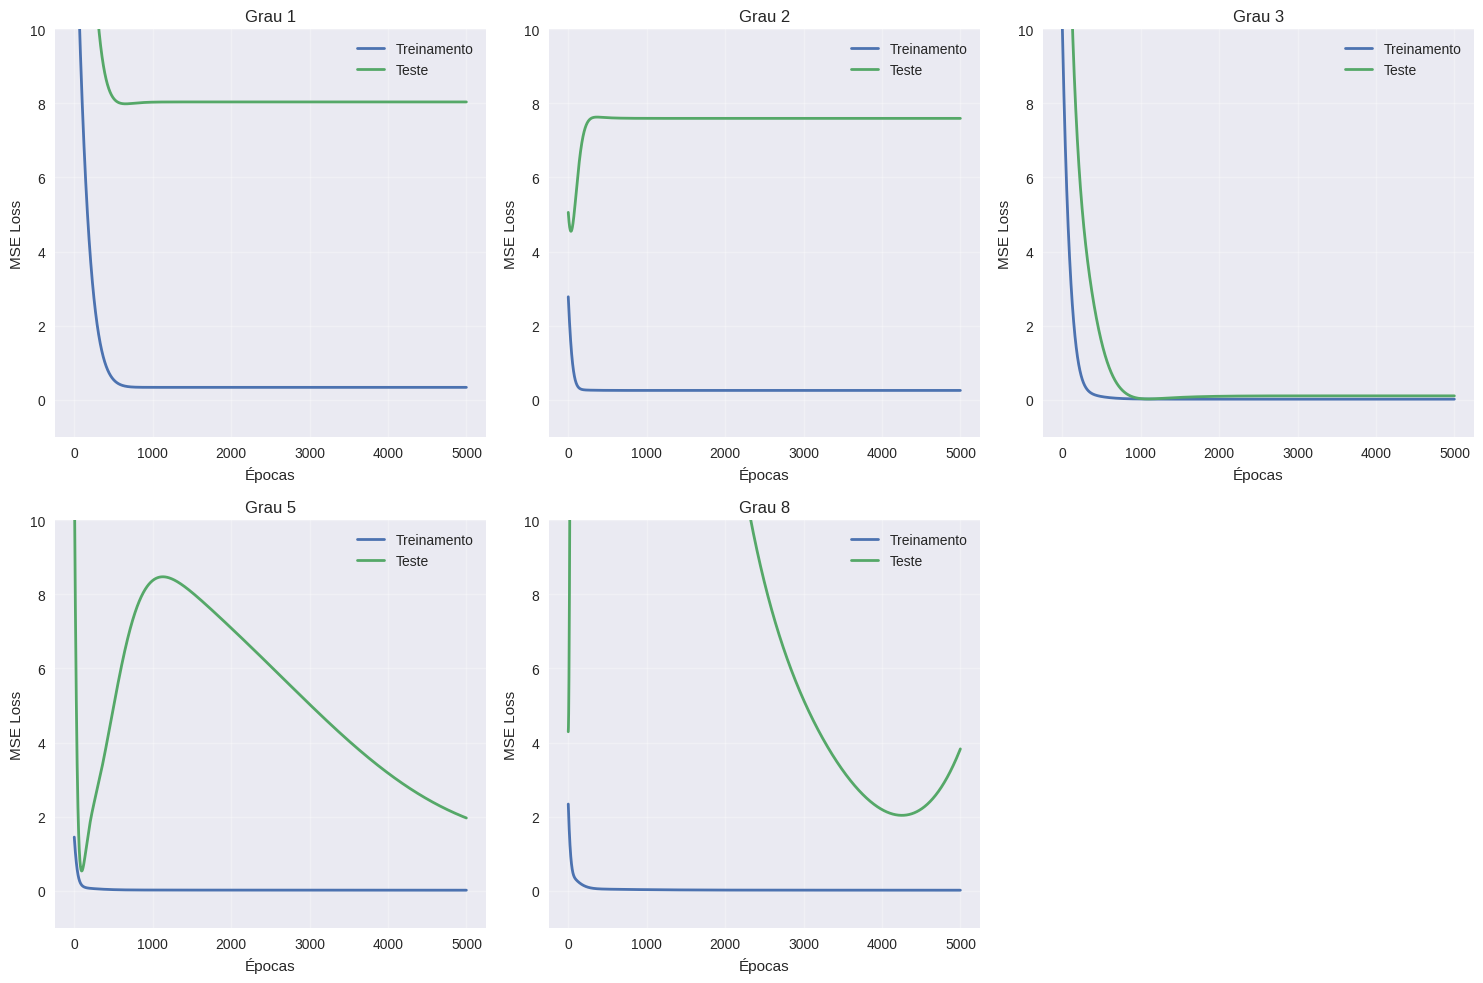

In [ ]:
# Visualizar curvas de loss
plt.figure(figsize=(15, 10))

for i, degree in enumerate(degrees):
    plt.subplot(2, 3, i + 1)

    train_losses = histories[degree]['train']
    test_losses = histories[degree]['test']

    plt.plot(train_losses, label='Treinamento', linewidth=2)
    plt.plot(test_losses, label='Teste', linewidth=2)
    plt.xlabel('Épocas')
    plt.ylabel('MSE Loss')
    plt.title(f'Grau {degree}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 10)

plt.tight_layout()
plt.show()

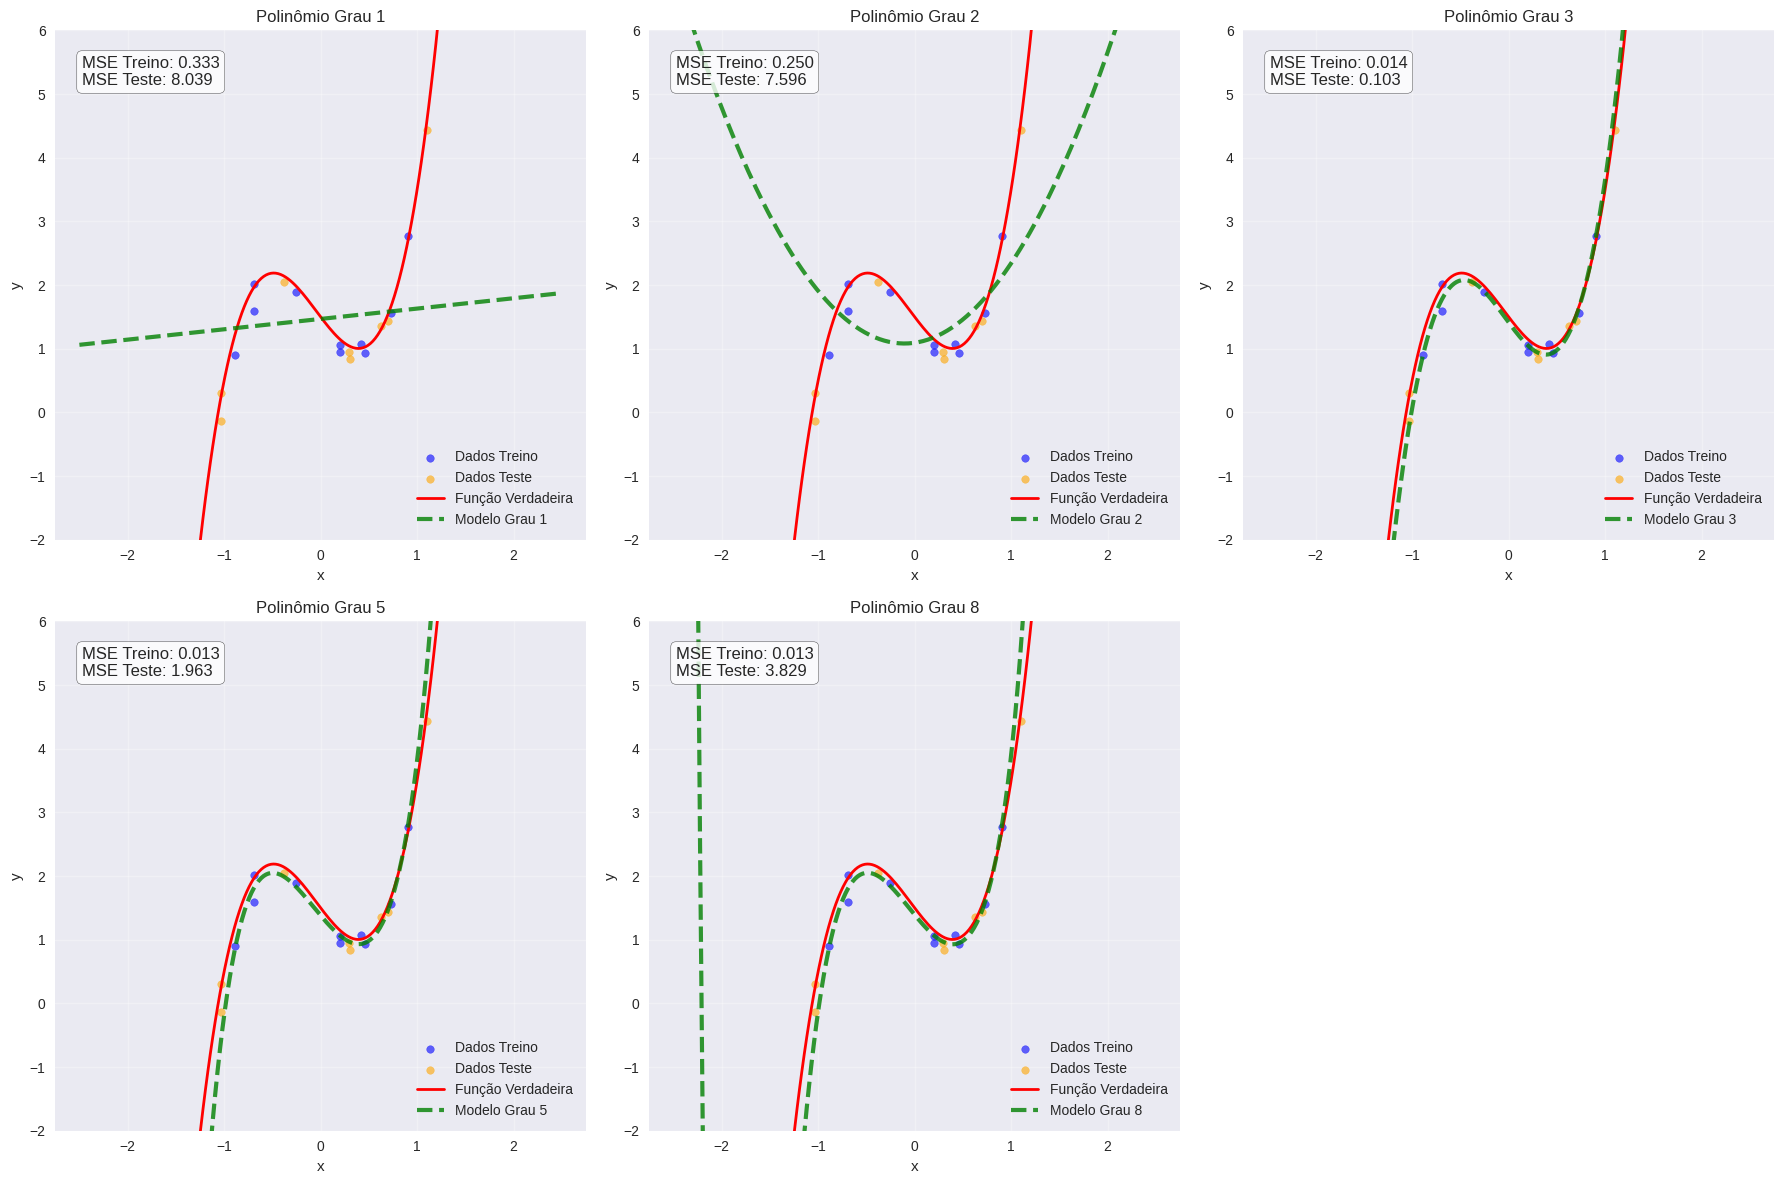

In [ ]:
# Visualizar as predições dos modelos
x_plot = torch.linspace(-2.5, 2.5, 200).unsqueeze(1)
y_true_plot = true_polynomial(x_plot)

plt.figure(figsize=(18, 12))

for i, degree in enumerate(degrees):
    plt.subplot(2, 3, i + 1)

    # Dados de treinamento
    plt.scatter(x_train, y_train_noisy, alpha=0.6, color='blue', s=30, label='Dados Treino')
    plt.scatter(x_test, y_test_noisy, alpha=0.6, color='orange', s=30, label='Dados Teste')

    # Função verdadeira
    plt.plot(x_plot.squeeze(), y_true_plot, 'r-', linewidth=2, label='Função Verdadeira')

    # Predição do modelo
    model = models[degree]
    model.eval()
    with torch.no_grad():
        y_pred_plot = model(x_plot)

    plt.plot(x_plot.squeeze(), y_pred_plot.squeeze(), 'g--', linewidth=3,
             label=f'Modelo Grau {degree}', alpha=0.8)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Polinômio Grau {degree}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-2, 6)

    # Calcular erros finais
    train_mse = histories[degree]['train'][-1]
    test_mse = histories[degree]['test'][-1]

    plt.text(0.05, 0.95, f'MSE Treino: {train_mse:.3f}\nMSE Teste: {test_mse:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             verticalalignment='top')

plt.tight_layout()
plt.show()

## 3. Bias-Variance Tradeoff

### 3.1 Fundamentos Matemáticos

O **Bias-Variance Tradeoff** é um conceito fundamental para entender por que modelos generalizam bem ou mal. Matematicamente, podemos decompor o erro esperado de um modelo:

$$E[(y - \hat{f}(x))^2] = \text{Bias}^2[\hat{f}(x)] + \text{Var}[\hat{f}(x)] + \sigma^2$$

Onde:
- **$y$**: valor verdadeiro
- **$\hat{f}(x)$**: predição do modelo
- **$\sigma^2$**: ruído irredutível nos dados

#### Definições Matemáticas:

1. **Bias (Viés)**: Mede o quanto a predição média do modelo se afasta do valor verdadeiro
   $$\text{Bias}[\hat{f}(x)] = E[\hat{f}(x)] - f(x)$$

2. **Variância**: Mede o quanto as predições variam entre diferentes conjuntos de treinamento
   $$\text{Var}[\hat{f}(x)] = E[(\hat{f}(x) - E[\hat{f}(x)])^2]$$

#### Interpretação Prática:

- **Alto Bias, Baixa Variância**: Modelo consistente, mas sistematicamente errado (underfitting)
- **Baixo Bias, Alta Variância**: Modelo correto em média, mas muito sensível aos dados (overfitting)
- **Objetivo**: Encontrar o equilíbrio que minimiza o erro total

## 4. Análise de Overfitting com MNIST

### 4.1 Efeito do Tamanho do Dataset de Treinamento

Vamos investigar como o tamanho do conjunto de treinamento afeta o overfitting usando o dataset MNIST. Iremos treinar redes neurais com diferentes quantidades de dados de treinamento e observar como isso impacta a generalização.

#### Hipóteses:
- **Poucos dados**: Alto overfitting (grande gap entre treino e validação)
- **Mais dados**: Menor overfitting e melhor generalização
- **Muitos dados**: Convergência para o limite teórico de performance

In [ ]:
# Carregar o dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalização específica do MNIST
])

# Carregar datasets completos
train_dataset_full = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Criar dataloader para teste (fixo para todas as experiências)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f'Dataset MNIST carregado!')
print(f'Tamanho do conjunto de treinamento completo: {len(train_dataset_full)}')
print(f'Tamanho do conjunto de teste: {len(test_dataset)}')

Dataset MNIST carregado!
Tamanho do conjunto de treinamento completo: 60000
Tamanho do conjunto de teste: 10000


### 4.2 Arquitetura da Rede Neural

In [ ]:
class MNISTClassifier(nn.Module):
    """Rede neural simples para classificação MNIST."""

    def __init__(self, hidden_size=128):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Testar a arquitetura
model_test = MNISTClassifier(hidden_size=128)
print(f'Arquitetura do modelo:')
print(model_test)

# Contar parâmetros
total_params = sum(p.numel() for p in model_test.parameters())
trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
print(f'\nTotal de parâmetros: {total_params:,}')
print(f'Parâmetros treináveis: {trainable_params:,}')

Arquitetura do modelo:
MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Total de parâmetros: 118,282
Parâmetros treináveis: 118,282


### 4.3 Função de Treinamento e Avaliação

In [ ]:
def train_mnist_model(model_class,train_loader, val_loader, epochs=20, lr=0.001, hidden_size=128):
    """Treina modelo MNIST e retorna histórico de métricas."""

    model = model_class(hidden_size=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avaliação no conjunto de validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

### 4.4 Experimento: Variando o Tamanho do Dataset de Treinamento

In [ ]:
# Definir diferentes tamanhos de dataset para o experimento
dataset_sizes = [100, 500, 10000]  # Poucos, médio e muitos dados
batch_size = 64
val_size = 1000  # Conjunto de validação fixo para comparação justa

# Separar dados de validação (primeiros 5000 exemplos do conjunto de teste)
val_indices = list(range(val_size))
val_dataset = torch.utils.data.Subset(train_dataset_full, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epochs = 20

# Inicializar dicionários para armazenar resultados
results_by_size = {}
models_by_size = {}

print("=== EXPERIMENTO: EFEITO DO TAMANHO DO DATASET ===")
print(f"Conjunto de validação fixo: {val_size} exemplos")
print(f"Tamanhos de treinamento a testar: {dataset_sizes}")
print(f"Épocas por experimento: {epochs}")

=== EXPERIMENTO: EFEITO DO TAMANHO DO DATASET ===
Conjunto de validação fixo: 1000 exemplos
Tamanhos de treinamento a testar: [100, 500, 10000]
Épocas por experimento: 20


In [ ]:
# Executar experimentos para cada tamanho de dataset
for size in dataset_sizes:
    print(f"Treinando com {size} exemplos...")

    # Criar subset do dataset de treinamento
    # Usar índices após os de validação para evitar overlap
    train_indices = list(range(val_size, val_size + size))
    train_subset = torch.utils.data.Subset(train_dataset_full, train_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Treinar modelo
    model, history = train_mnist_model(
        model_class=MNISTClassifier,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001,
        hidden_size=128
    )

    # Armazenar resultados
    results_by_size[size] = history
    models_by_size[size] = model

    print(f"Concluído para {size} exemplos")

print("Todos os experimentos concluídos!")

Treinando com 100 exemplos...
Época 5/20: Train Loss: 1.3551, Train Acc: 67.00% | Val Loss: 1.5410, Val Acc: 52.80%
Época 10/20: Train Loss: 0.4850, Train Acc: 94.00% | Val Loss: 0.9503, Val Acc: 72.10%
Época 15/20: Train Loss: 0.1225, Train Acc: 98.00% | Val Loss: 0.8896, Val Acc: 72.80%
Época 20/20: Train Loss: 0.0293, Train Acc: 100.00% | Val Loss: 0.9289, Val Acc: 72.90%
Concluído para 100 exemplos
Treinando com 500 exemplos...
Época 5/20: Train Loss: 0.4061, Train Acc: 90.20% | Val Loss: 0.5343, Val Acc: 84.30%
Época 10/20: Train Loss: 0.1173, Train Acc: 98.60% | Val Loss: 0.4695, Val Acc: 85.50%
Época 15/20: Train Loss: 0.0351, Train Acc: 100.00% | Val Loss: 0.4819, Val Acc: 86.20%
Época 20/20: Train Loss: 0.0142, Train Acc: 100.00% | Val Loss: 0.5055, Val Acc: 85.90%
Concluído para 500 exemplos
Treinando com 10000 exemplos...
Época 5/20: Train Loss: 0.0900, Train Acc: 97.32% | Val Loss: 0.2049, Val Acc: 95.00%
Época 10/20: Train Loss: 0.0220, Train Acc: 99.51% | Val Loss: 0.2225

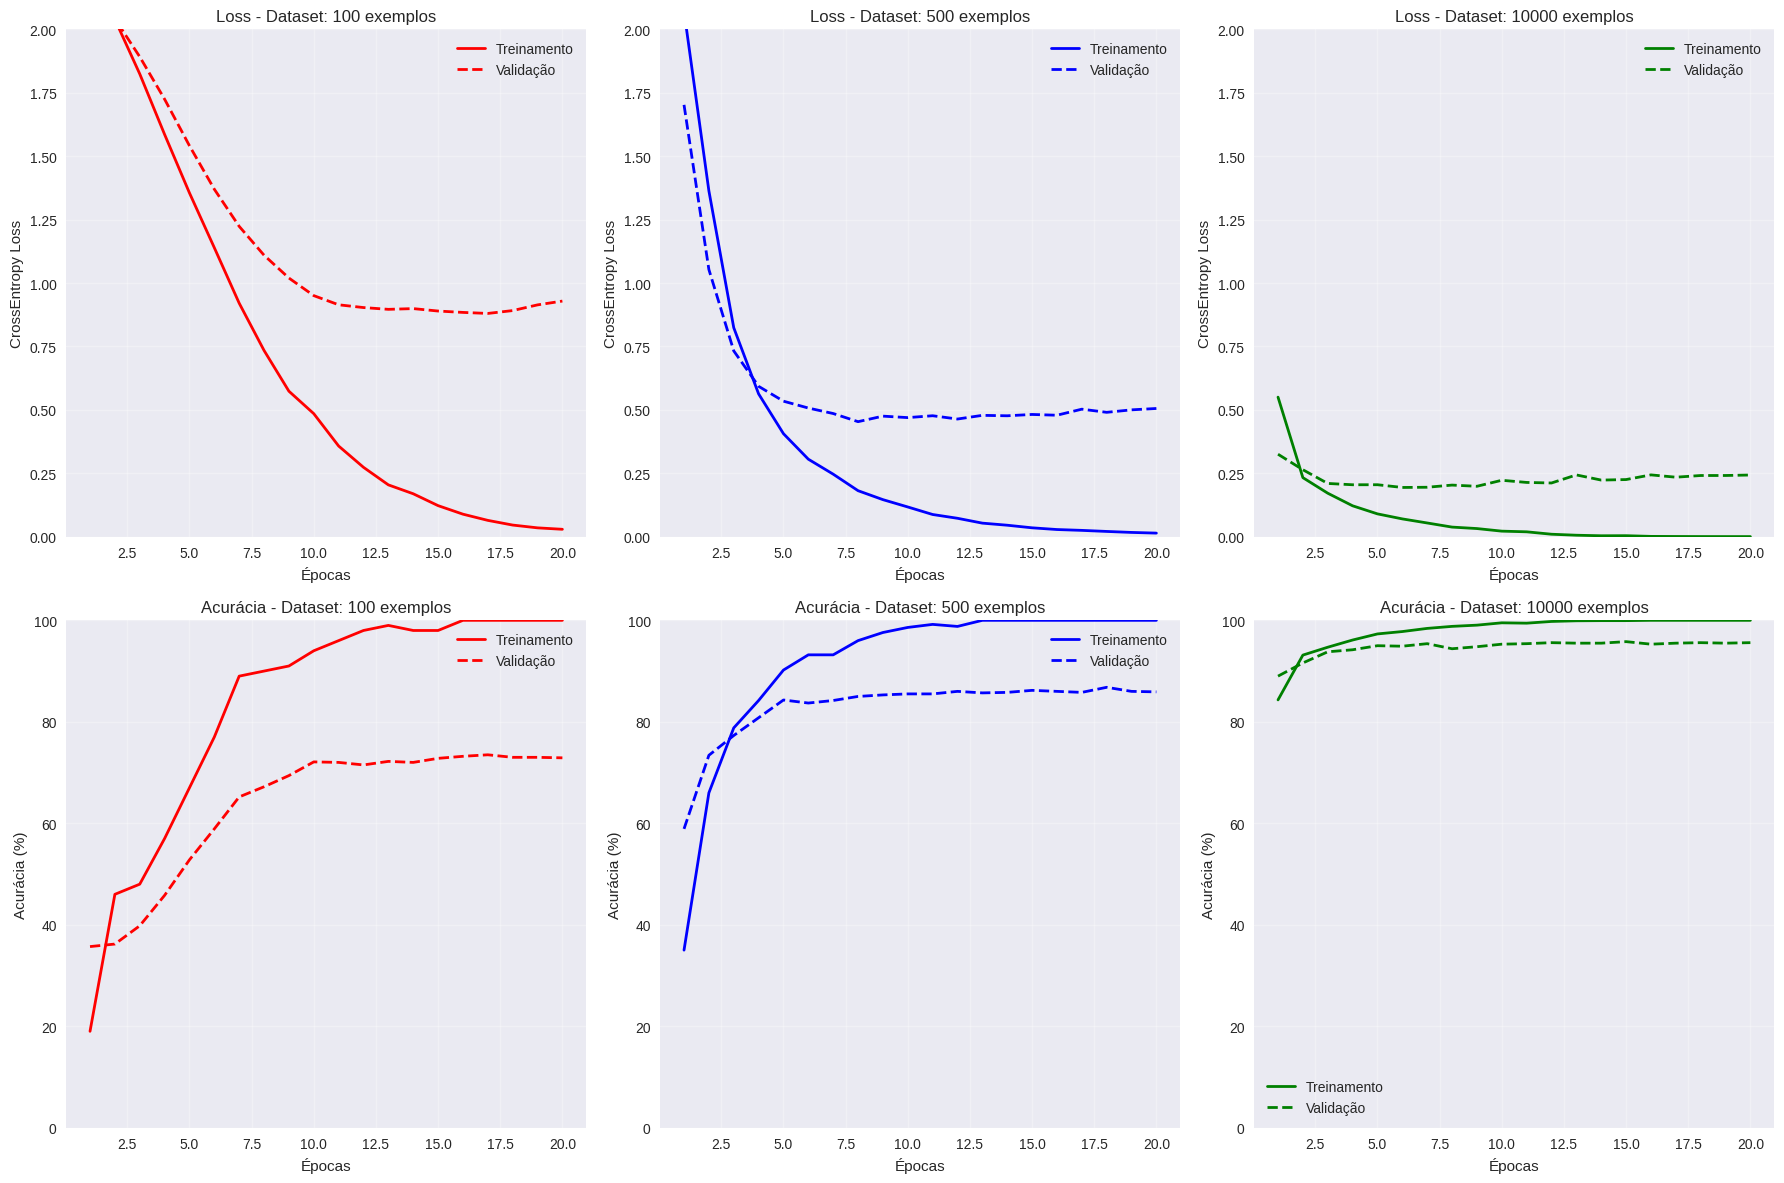

In [ ]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, size in enumerate(dataset_sizes):
    history = results_by_size[size]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Validação')
    ax_loss.set_title(f'Loss - Dataset: {size} exemplos')
    ax_loss.set_xlabel('Épocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acurácia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Validação')
    ax_acc.set_title(f'Acurácia - Dataset: {size} exemplos')
    ax_acc.set_xlabel('Épocas')
    ax_acc.set_ylabel('Acurácia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

plt.tight_layout()
plt.show()

### 4.5 Análise dos Resultados

In [ ]:
# Analisar resultados finais
print("=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\\n")

analysis_results = []
for size in dataset_sizes:
    history = results_by_size[size]

    # Métricas finais (última época)
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    # Gap entre treino e validação (indicador de overfitting)
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Dataset Size': size,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

    print(f"📈 Dataset com {size} exemplos:")
    print(f"   Loss: Treino {final_train_loss:.4f} | Validação {final_val_loss:.4f} | Gap {loss_gap:.4f}")
    print(f"   Acc:  Treino {final_train_acc:.2f}% | Validação {final_val_acc:.2f}% | Gap {acc_gap:.2f}%")
    print()

# Criar tabela resumo
df_analysis = pd.DataFrame(analysis_results)
print("📋 TABELA RESUMO:")
print(df_analysis.to_string(index=False))

=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\n
📈 Dataset com 100 exemplos:
   Loss: Treino 0.0293 | Validação 0.9289 | Gap 0.8995
   Acc:  Treino 100.00% | Validação 72.90% | Gap 27.10%

📈 Dataset com 500 exemplos:
   Loss: Treino 0.0142 | Validação 0.5055 | Gap 0.4913
   Acc:  Treino 100.00% | Validação 85.90% | Gap 14.10%

📈 Dataset com 10000 exemplos:
   Loss: Treino 0.0005 | Validação 0.2432 | Gap 0.2427
   Acc:  Treino 100.00% | Validação 95.60% | Gap 4.40%

📋 TABELA RESUMO:
 Dataset Size Train Loss Val Loss Loss Gap Train Acc Val Acc Acc Gap
          100     0.0293   0.9289   0.8995   100.00%  72.90%  27.10%
          500     0.0142   0.5055   0.4913   100.00%  85.90%  14.10%
        10000     0.0005   0.2432   0.2427   100.00%  95.60%   4.40%


### 4.6 Visualizações Comparativas

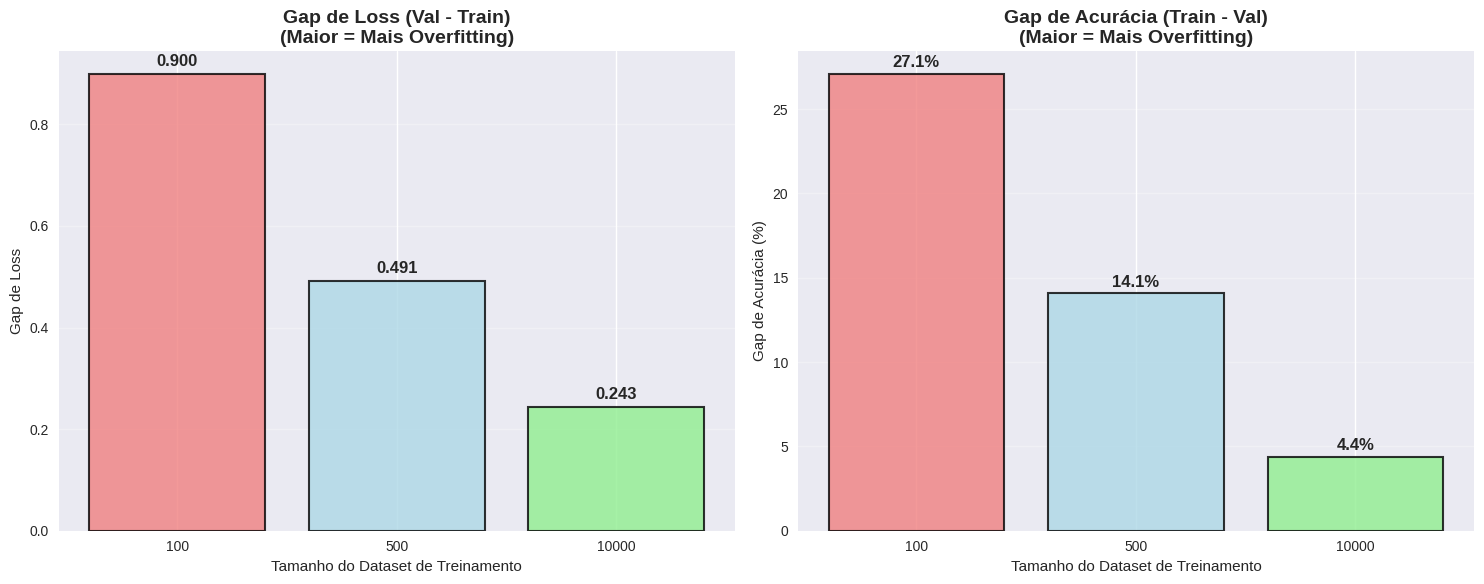

In [ ]:
# Gráfico de barras comparativo do gap de overfitting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Extrair dados para os gráficos
dataset_sizes_str = [str(size) for size in dataset_sizes]
loss_gaps = []
acc_gaps = []

for size in dataset_sizes:
    history = results_by_size[size]
    loss_gap = history['val_losses'][-1] - history['train_losses'][-1]
    acc_gap = history['train_accuracies'][-1] - history['val_accuracies'][-1]
    loss_gaps.append(loss_gap)
    acc_gaps.append(acc_gap)

# Gráfico de gap de loss
bars1 = ax1.bar(dataset_sizes_str, loss_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_title('Gap de Loss (Val - Train)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tamanho do Dataset de Treinamento')
ax1.set_ylabel('Gap de Loss')
ax1.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars1, loss_gaps):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de gap de acurácia
bars2 = ax2.bar(dataset_sizes_str, acc_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_title('Gap de Acurácia (Train - Val)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tamanho do Dataset de Treinamento')
ax2.set_ylabel('Gap de Acurácia (%)')
ax2.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars2, acc_gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 4.7 Conclusões do Experimento

#### Implicações Práticas:

- **Mais dados = Melhor generalização**: O aumento do tamanho do dataset reduziu consistentemente o overfitting
- **Bias-Variance Tradeoff**: Datasets maiores reduzem a variância do modelo
- **Capacidade do Modelo**: A mesma arquitetura se beneficia diferentemente dependendo da quantidade de dados

#### Insights Teóricos:

- O **ruído nos dados** tem menos impacto quando há mais exemplos diversos
- A **complexidade do modelo** deve ser ajustada de acordo com a quantidade de dados disponíveis

## Exercício

Usando o dataset MNIST já carregado (500 exemplos), compare três arquiteturas diferentes e identifique qual apresenta menor overfitting. Analise os gaps de loss e acurácia entre treinamento e validação.

## Resolução exercício

### Definição das arquiteturas dos modelos

In [ ]:
class MNISTClassifier1(nn.Module):
    """Rede neural simples para classificação MNIST."""

    def __init__(self):
        super(MNISTClassifier1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Testar a arquitetura
model = MNISTClassifier1()
print(f'Arquitetura do modelo:')
print(model)

# Contar parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal de parâmetros: {total_params:,}')
print(f'Parâmetros treináveis: {trainable_params:,}')

Arquitetura do modelo:
MNISTClassifier1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total de parâmetros: 101,770
Parâmetros treináveis: 101,770


In [ ]:
class MNISTClassifier2(nn.Module):
    """Rede neural simples para classificação MNIST."""

    def __init__(self):
        super(MNISTClassifier2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 10)


    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Testar a arquitetura
model = MNISTClassifier2()
print(f'Arquitetura do modelo:')
print(model)

# Contar parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal de parâmetros: {total_params:,}')
print(f'Parâmetros treináveis: {trainable_params:,}')

Arquitetura do modelo:
MNISTClassifier2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
)

Total de parâmetros: 270,218
Parâmetros treináveis: 270,218


In [ ]:
class MNISTClassifier3(nn.Module):
    """Rede neural simples para classificação MNIST."""

    def __init__(self):
        super(MNISTClassifier3, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Testar a arquitetura
model = MNISTClassifier3()
print(f'Arquitetura do modelo:')
print(model)

# Contar parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal de parâmetros: {total_params:,}')
print(f'Parâmetros treináveis: {trainable_params:,}')

Arquitetura do modelo:
MNISTClassifier3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Total de parâmetros: 407,050
Parâmetros treináveis: 407,050


In [ ]:
def train_mnist_model(model_class, train_loader, val_loader, epochs=20, lr=0.001):
    """Treina modelo MNIST e retorna histórico de métricas."""

    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avaliação no conjunto de validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

In [ ]:
# Definir diferentes tamanhos de dataset para o experimento
dataset_sizes = [100, 500, 10000]  # Poucos, médio e muitos dados
batch_size = 64
val_size = 1000  # Conjunto de validação fixo para comparação justa

# Separar dados de validação (primeiros 5000 exemplos do conjunto de teste)
val_indices = list(range(val_size))
val_dataset = torch.utils.data.Subset(train_dataset_full, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epochs = 20

# Inicializar dicionários para armazenar resultados
models = [
      {"results_by_size": {}, "models_by_size": {}},
      {"results_by_size": {}, "models_by_size": {}},
      {"results_by_size": {}, "models_by_size": {}}
      ]



print("=== EXPERIMENTO: EFEITO DO TAMANHO DO DATASET ===")
print(f"Conjunto de validação fixo: {val_size} exemplos")
print(f"Tamanhos de treinamento a testar: {dataset_sizes}")
print(f"Épocas por experimento: {epochs}")

=== EXPERIMENTO: EFEITO DO TAMANHO DO DATASET ===
Conjunto de validação fixo: 1000 exemplos
Tamanhos de treinamento a testar: [100, 500, 10000]
Épocas por experimento: 20


### Treinamento dos modelos

In [ ]:
 # Executar experimentos para cada tamanho de dataset
for size in dataset_sizes:
    print(f"Treinando com {size} exemplos...")

    # Criar subset do dataset de treinamento
    # Usar índices após os de validação para evitar overlap
    train_indices = list(range(val_size, val_size + size))
    train_subset = torch.utils.data.Subset(train_dataset_full, train_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Treinar modelo
    first_model, first_history = train_mnist_model(
        model_class=MNISTClassifier1,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001
    )

    # Armazenar resultados
    models[0]["results_by_size"][size] = first_history
    models[0]["models_by_size"][size] = first_model

    print(f"Concluído para {size} exemplos")

print("Todos os experimentos concluídos!")

Treinando com 100 exemplos...
Época 5/20: Train Loss: 1.0318, Train Acc: 77.00% | Val Loss: 1.3330, Val Acc: 62.10%
Época 10/20: Train Loss: 0.3594, Train Acc: 98.00% | Val Loss: 0.9573, Val Acc: 70.80%
Época 15/20: Train Loss: 0.1194, Train Acc: 99.00% | Val Loss: 0.9151, Val Acc: 70.50%
Época 20/20: Train Loss: 0.0502, Train Acc: 100.00% | Val Loss: 0.9025, Val Acc: 71.80%
Concluído para 100 exemplos
Treinando com 500 exemplos...
Época 5/20: Train Loss: 0.4101, Train Acc: 90.80% | Val Loss: 0.5496, Val Acc: 83.30%
Época 10/20: Train Loss: 0.1528, Train Acc: 98.20% | Val Loss: 0.4729, Val Acc: 85.50%
Época 15/20: Train Loss: 0.0695, Train Acc: 99.60% | Val Loss: 0.4674, Val Acc: 85.50%
Época 20/20: Train Loss: 0.0334, Train Acc: 100.00% | Val Loss: 0.4817, Val Acc: 85.30%
Concluído para 500 exemplos
Treinando com 10000 exemplos...
Época 5/20: Train Loss: 0.1102, Train Acc: 96.96% | Val Loss: 0.2004, Val Acc: 94.30%
Época 10/20: Train Loss: 0.0313, Train Acc: 99.32% | Val Loss: 0.1923,

In [ ]:
 # Executar experimentos para cada tamanho de dataset
for size in dataset_sizes:
    print(f"Treinando com {size} exemplos...")

    # Criar subset do dataset de treinamento
    # Usar índices após os de validação para evitar overlap
    train_indices = list(range(val_size, val_size + size))
    train_subset = torch.utils.data.Subset(train_dataset_full, train_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Treinar modelo
    second_model, second_history = train_mnist_model(
        model_class=MNISTClassifier2,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001,
    )

    # Armazenar resultados
    models[1]["results_by_size"][size] = second_history
    models[1]["models_by_size"][size] = second_model

    print(f"Concluído para {size} exemplos")

print("Todos os experimentos concluídos!")

Treinando com 100 exemplos...
Época 5/20: Train Loss: 1.3524, Train Acc: 65.00% | Val Loss: 1.6124, Val Acc: 50.70%
Época 10/20: Train Loss: 0.3201, Train Acc: 94.00% | Val Loss: 1.1328, Val Acc: 64.70%
Época 15/20: Train Loss: 0.0344, Train Acc: 100.00% | Val Loss: 1.2243, Val Acc: 70.00%
Época 20/20: Train Loss: 0.0028, Train Acc: 100.00% | Val Loss: 1.4501, Val Acc: 71.20%
Concluído para 100 exemplos
Treinando com 500 exemplos...
Época 5/20: Train Loss: 0.4103, Train Acc: 88.00% | Val Loss: 0.5828, Val Acc: 81.30%
Época 10/20: Train Loss: 0.0800, Train Acc: 98.20% | Val Loss: 0.5273, Val Acc: 85.40%
Época 15/20: Train Loss: 0.0095, Train Acc: 100.00% | Val Loss: 0.5588, Val Acc: 86.30%
Época 20/20: Train Loss: 0.0034, Train Acc: 100.00% | Val Loss: 0.5874, Val Acc: 86.30%
Concluído para 500 exemplos
Treinando com 10000 exemplos...
Época 5/20: Train Loss: 0.0683, Train Acc: 97.92% | Val Loss: 0.2271, Val Acc: 93.40%
Época 10/20: Train Loss: 0.0339, Train Acc: 98.90% | Val Loss: 0.203

In [ ]:
# Executar experimentos para cada tamanho de dataset
for size in dataset_sizes:
    print(f"Treinando com {size} exemplos...")

    # Criar subset do dataset de treinamento
    # Usar índices após os de validação para evitar overlap
    train_indices = list(range(val_size, val_size + size))
    train_subset = torch.utils.data.Subset(train_dataset_full, train_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Treinar modelo
    third_model, third_history = train_mnist_model(
        model_class=MNISTClassifier3,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001,
    )

    # Armazenar resultados
    models[2]["results_by_size"][size] = third_history
    models[2]["models_by_size"][size] = third_model

    print(f"Concluído para {size} exemplos")

print("Todos os experimentos concluídos!")

Treinando com 100 exemplos...
Época 5/20: Train Loss: 0.4473, Train Acc: 96.00% | Val Loss: 0.9818, Val Acc: 71.10%
Época 10/20: Train Loss: 0.0762, Train Acc: 100.00% | Val Loss: 0.9540, Val Acc: 70.20%
Época 15/20: Train Loss: 0.0139, Train Acc: 100.00% | Val Loss: 0.9674, Val Acc: 71.70%
Época 20/20: Train Loss: 0.0060, Train Acc: 100.00% | Val Loss: 1.0022, Val Acc: 72.50%
Concluído para 100 exemplos
Treinando com 500 exemplos...
Época 5/20: Train Loss: 0.1945, Train Acc: 96.00% | Val Loss: 0.4714, Val Acc: 86.60%
Época 10/20: Train Loss: 0.0403, Train Acc: 100.00% | Val Loss: 0.4563, Val Acc: 86.30%
Época 15/20: Train Loss: 0.0143, Train Acc: 100.00% | Val Loss: 0.4692, Val Acc: 86.40%
Época 20/20: Train Loss: 0.0078, Train Acc: 100.00% | Val Loss: 0.4811, Val Acc: 86.40%
Concluído para 500 exemplos
Treinando com 10000 exemplos...
Época 5/20: Train Loss: 0.0538, Train Acc: 98.45% | Val Loss: 0.1970, Val Acc: 95.40%
Época 10/20: Train Loss: 0.0054, Train Acc: 99.91% | Val Loss: 0.1

### Curvas de treinamento

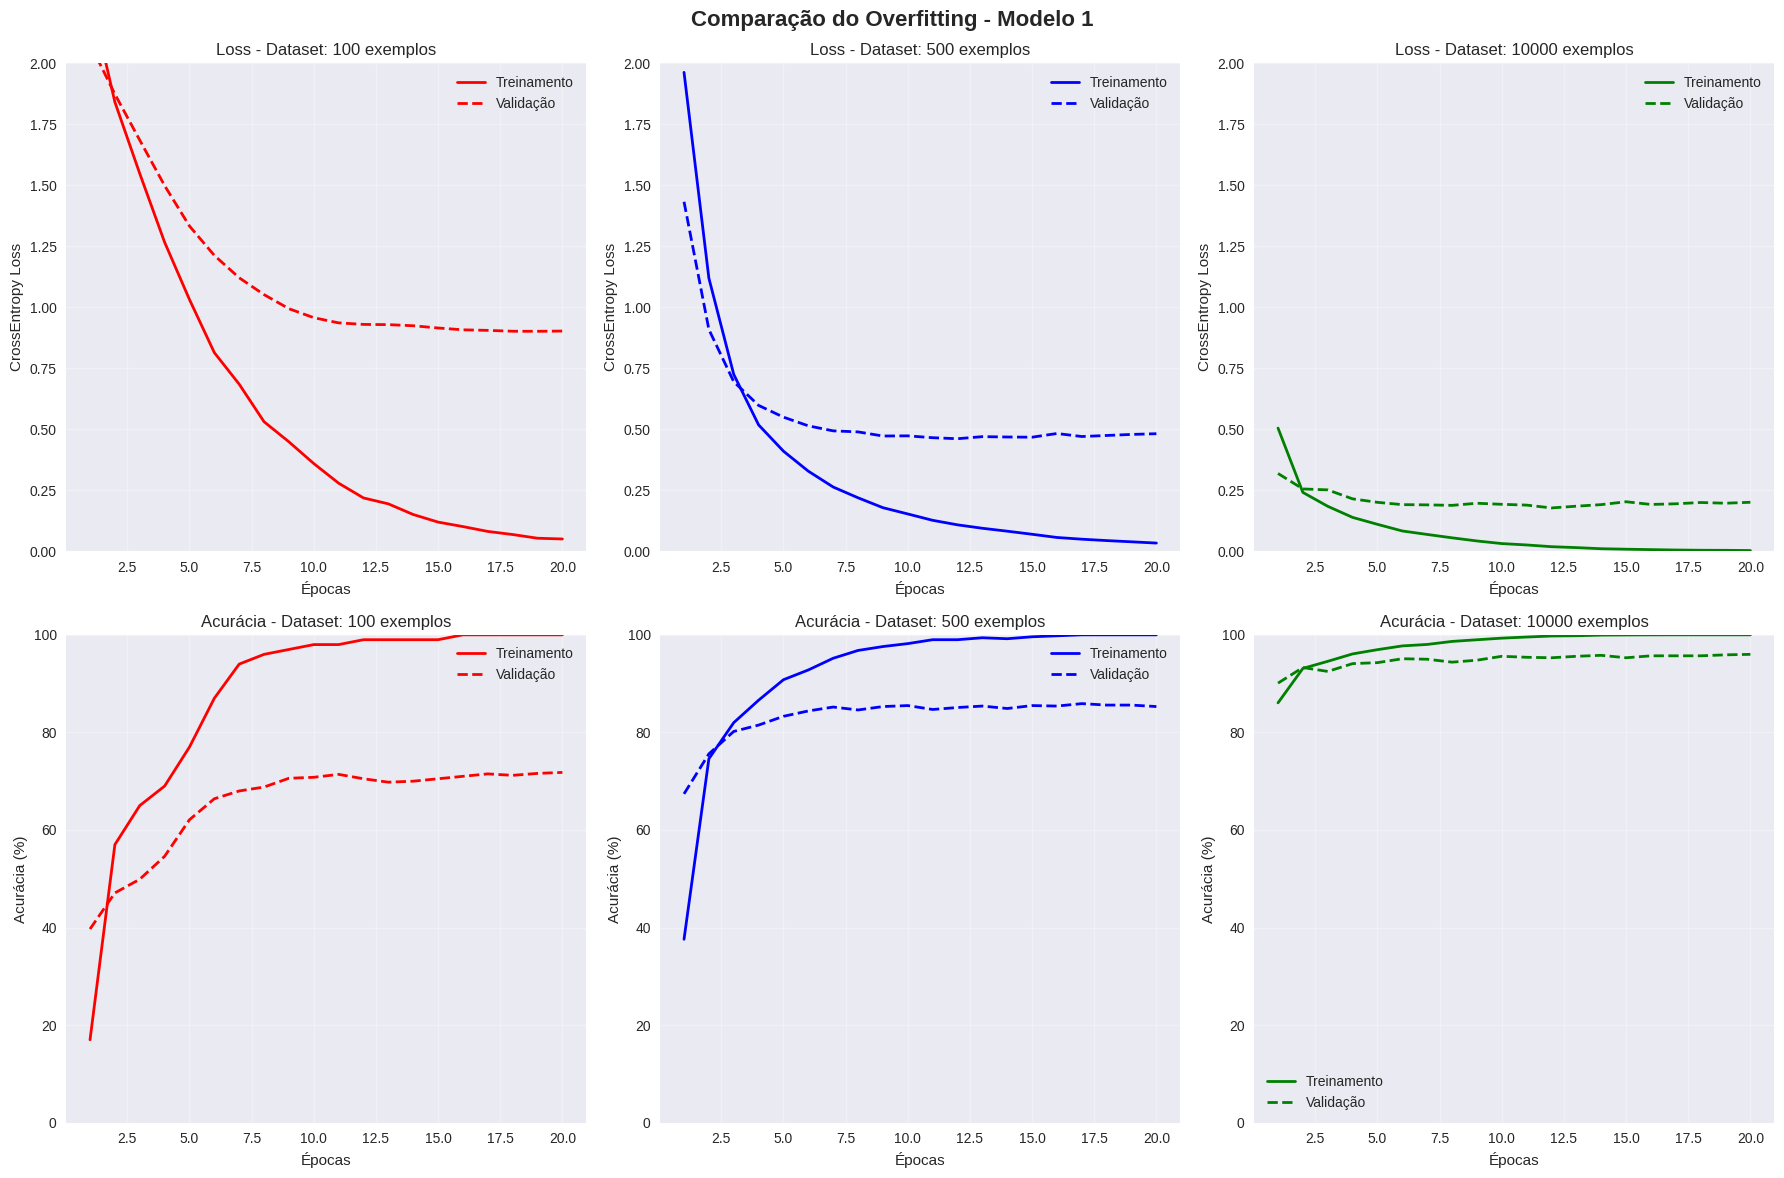

In [ ]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, size in enumerate(dataset_sizes):
    history = models[0]["results_by_size"][size]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Validação')
    ax_loss.set_title(f'Loss - Dataset: {size} exemplos')
    ax_loss.set_xlabel('Épocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acurácia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Validação')
    ax_acc.set_title(f'Acurácia - Dataset: {size} exemplos')
    ax_acc.set_xlabel('Épocas')
    ax_acc.set_ylabel('Acurácia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

fig.suptitle('Comparação do Overfitting - Modelo 1', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

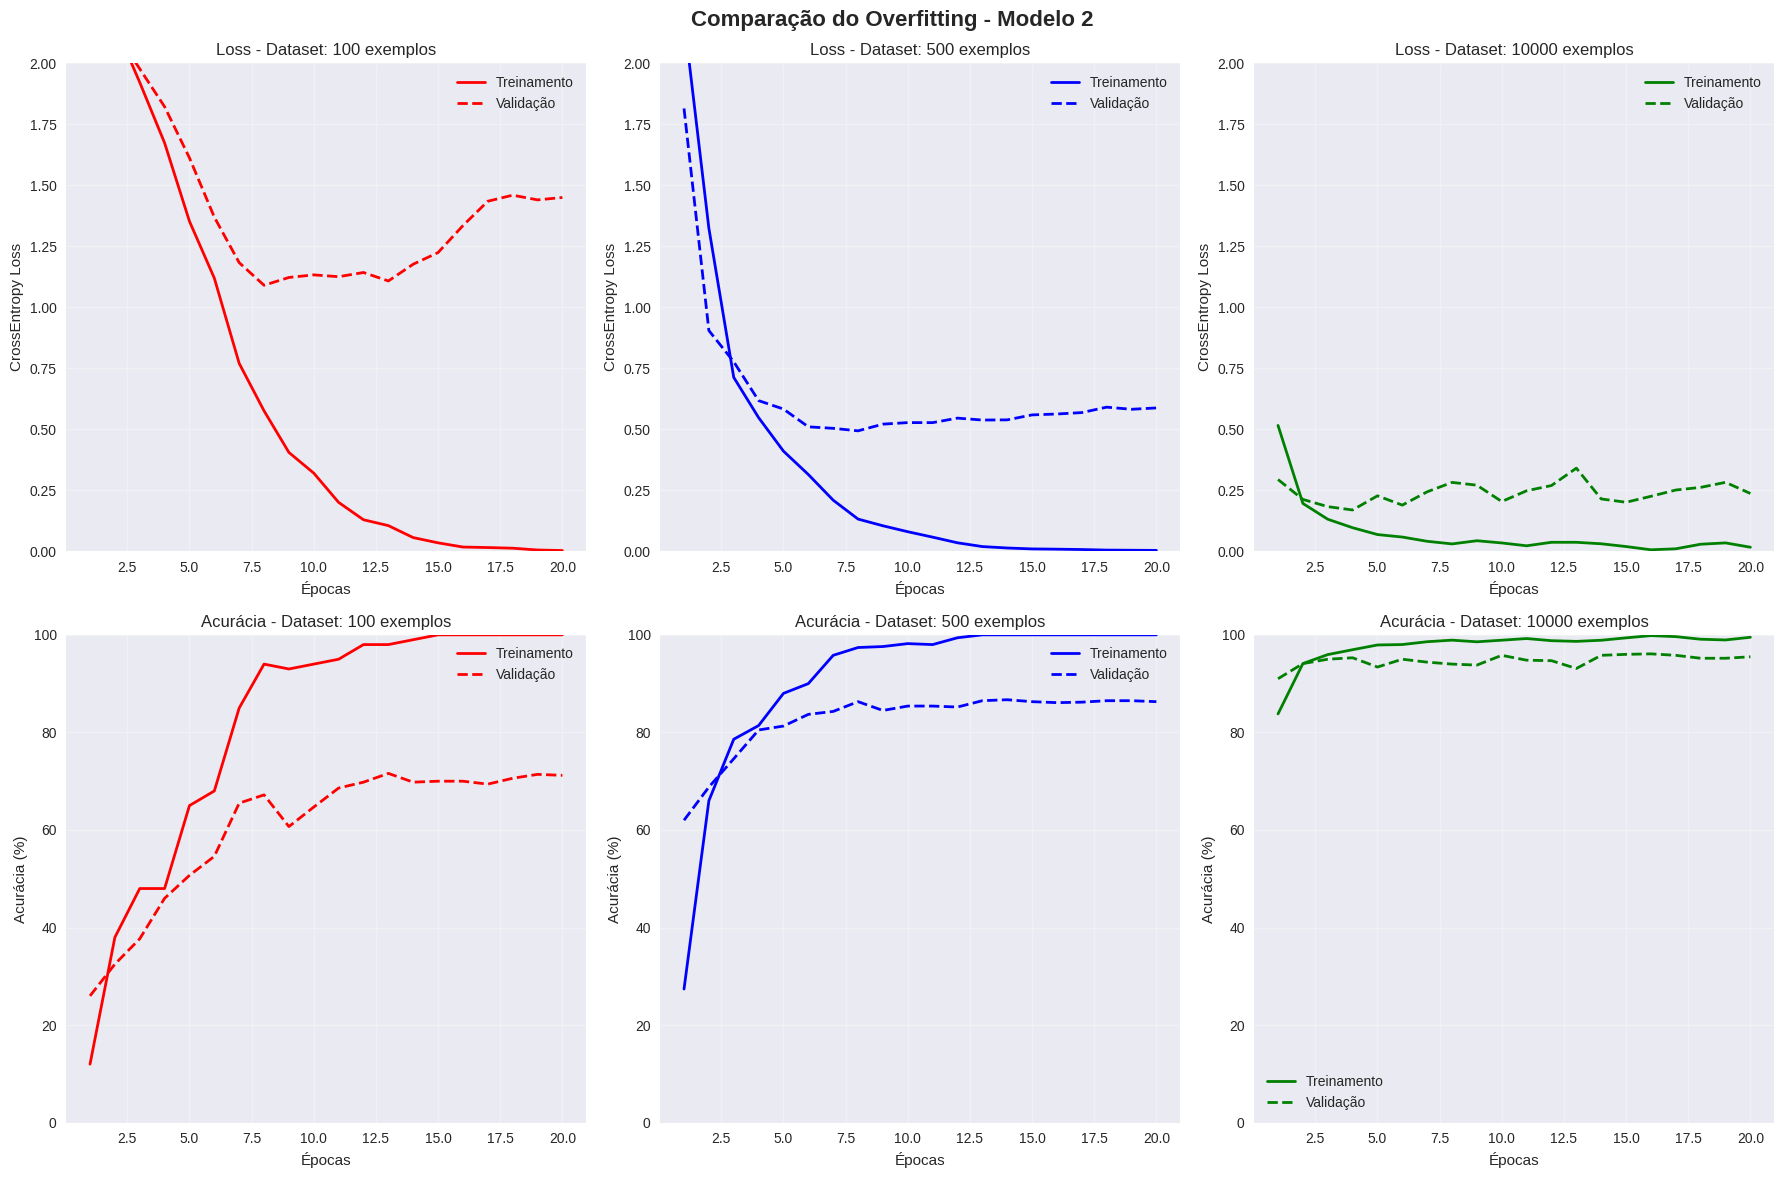

In [ ]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, size in enumerate(dataset_sizes):
    history = models[1]["results_by_size"][size]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Validação')
    ax_loss.set_title(f'Loss - Dataset: {size} exemplos')
    ax_loss.set_xlabel('Épocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acurácia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Validação')
    ax_acc.set_title(f'Acurácia - Dataset: {size} exemplos')
    ax_acc.set_xlabel('Épocas')
    ax_acc.set_ylabel('Acurácia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

fig.suptitle('Comparação do Overfitting - Modelo 2', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

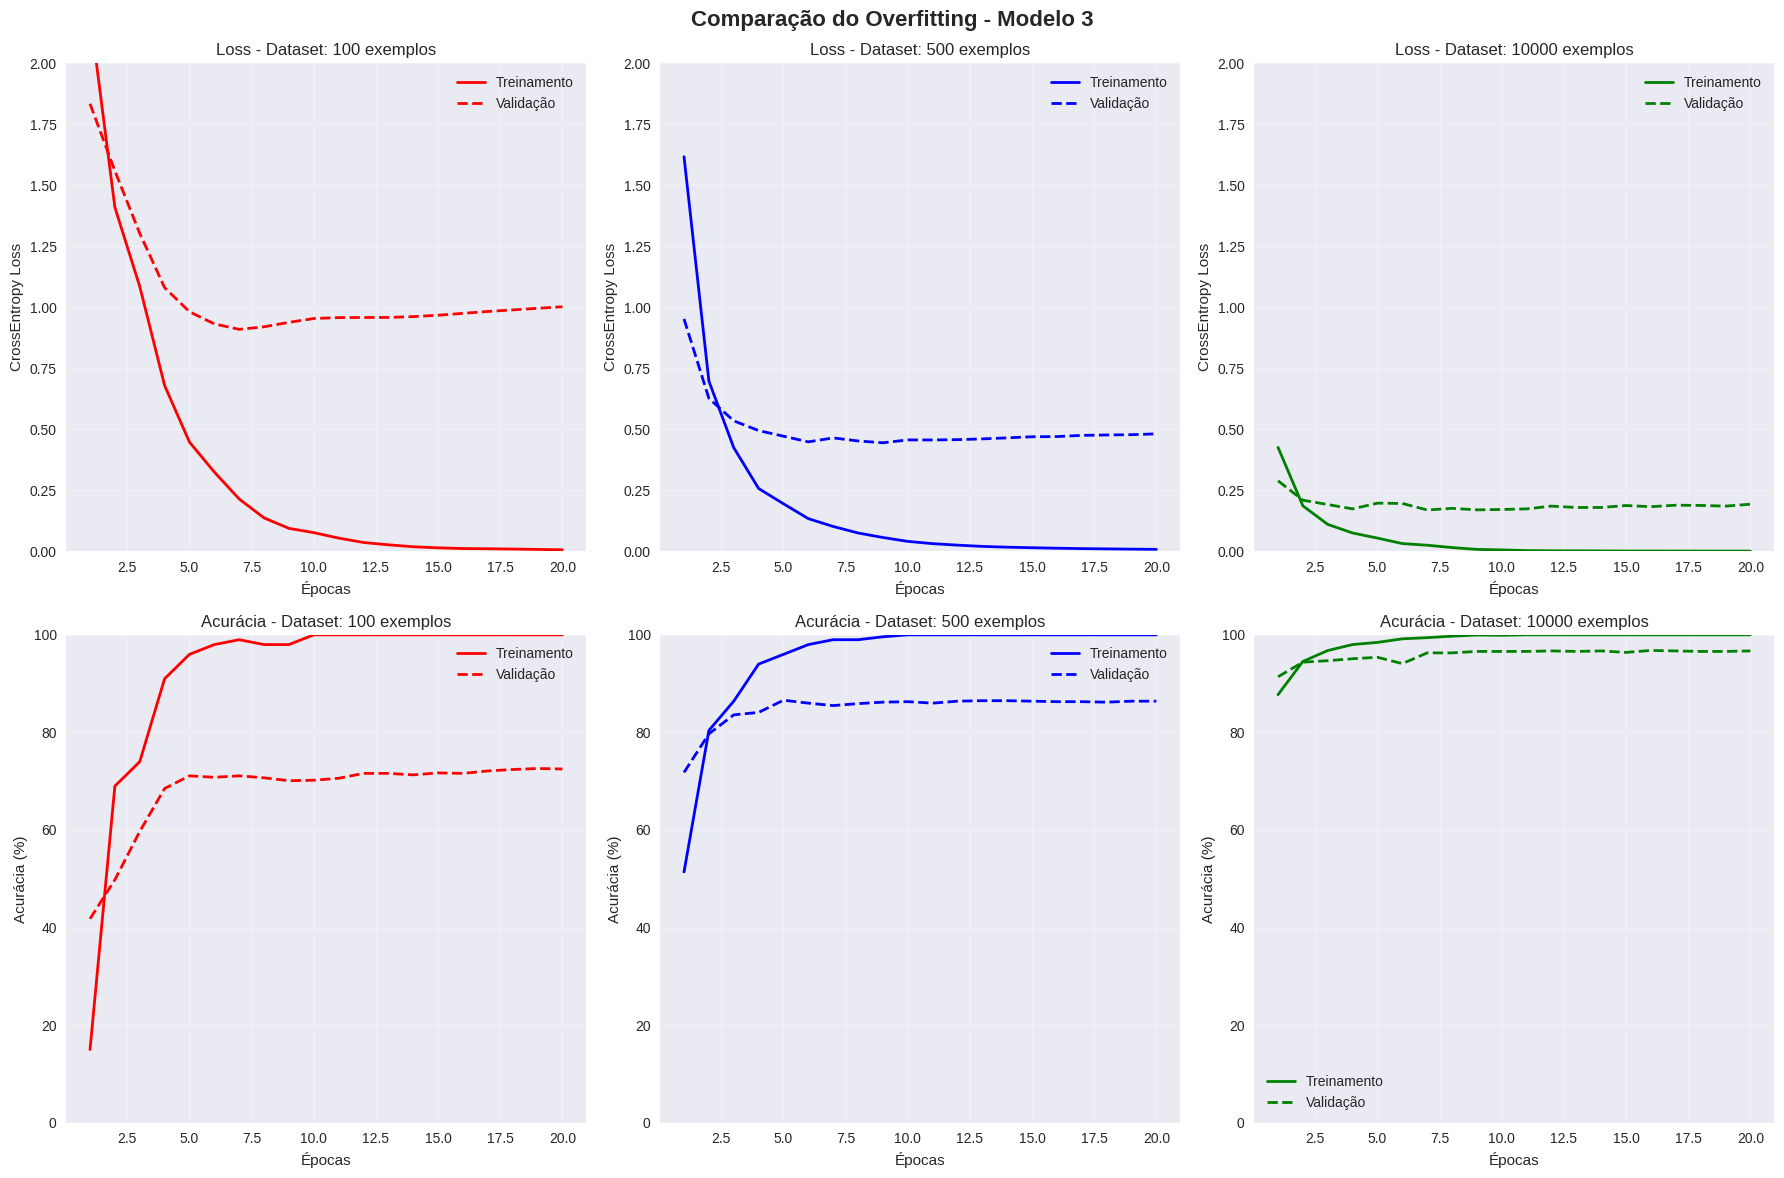

In [ ]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, size in enumerate(dataset_sizes):
    history = models[2]["results_by_size"][size]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Validação')
    ax_loss.set_title(f'Loss - Dataset: {size} exemplos')
    ax_loss.set_xlabel('Épocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acurácia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Validação')
    ax_acc.set_title(f'Acurácia - Dataset: {size} exemplos')
    ax_acc.set_xlabel('Épocas')
    ax_acc.set_ylabel('Acurácia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

fig.suptitle('Comparação do Overfitting - Modelo 3', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

### Análise de Overfitting

In [ ]:
# Analisar resultados finais
print("=== MODELO 1 ===\\n")
print("=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\\n")

analysis_results = []
for size in dataset_sizes:
    history = models[0]["results_by_size"][size]

    # Métricas finais (última época)
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    # Gap entre treino e validação (indicador de overfitting)
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Dataset Size': size,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

    print(f"📈 Dataset com {size} exemplos:")
    print(f"   Loss: Treino {final_train_loss:.4f} | Validação {final_val_loss:.4f} | Gap {loss_gap:.4f}")
    print(f"   Acc:  Treino {final_train_acc:.2f}% | Validação {final_val_acc:.2f}% | Gap {acc_gap:.2f}%")
    print()

# Criar tabela resumo
df_analysis = pd.DataFrame(analysis_results)
print("📋 TABELA RESUMO:")
print(df_analysis.to_string(index=False))

=== MODELO 1 ===\n
=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\n
📈 Dataset com 100 exemplos:
   Loss: Treino 0.0502 | Validação 0.9025 | Gap 0.8523
   Acc:  Treino 100.00% | Validação 71.80% | Gap 28.20%

📈 Dataset com 500 exemplos:
   Loss: Treino 0.0334 | Validação 0.4817 | Gap 0.4483
   Acc:  Treino 100.00% | Validação 85.30% | Gap 14.70%

📈 Dataset com 10000 exemplos:
   Loss: Treino 0.0029 | Validação 0.2007 | Gap 0.1978
   Acc:  Treino 100.00% | Validação 96.00% | Gap 4.00%

📋 TABELA RESUMO:
 Dataset Size Train Loss Val Loss Loss Gap Train Acc Val Acc Acc Gap
          100     0.0502   0.9025   0.8523   100.00%  71.80%  28.20%
          500     0.0334   0.4817   0.4483   100.00%  85.30%  14.70%
        10000     0.0029   0.2007   0.1978   100.00%  96.00%   4.00%


In [ ]:
# Analisar resultados finais
print("=== MODELO 2 ===\\n")
print("=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\\n")

analysis_results = []
for size in dataset_sizes:
    history = models[1]["results_by_size"][size]

    # Métricas finais (última época)
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    # Gap entre treino e validação (indicador de overfitting)
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Dataset Size': size,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

    print(f"📈 Dataset com {size} exemplos:")
    print(f"   Loss: Treino {final_train_loss:.4f} | Validação {final_val_loss:.4f} | Gap {loss_gap:.4f}")
    print(f"   Acc:  Treino {final_train_acc:.2f}% | Validação {final_val_acc:.2f}% | Gap {acc_gap:.2f}%")
    print()

# Criar tabela resumo
df_analysis = pd.DataFrame(analysis_results)
print("📋 TABELA RESUMO:")
print(df_analysis.to_string(index=False))

=== MODELO 2 ===\n
=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\n
📈 Dataset com 100 exemplos:
   Loss: Treino 0.0028 | Validação 1.4501 | Gap 1.4472
   Acc:  Treino 100.00% | Validação 71.20% | Gap 28.80%

📈 Dataset com 500 exemplos:
   Loss: Treino 0.0034 | Validação 0.5874 | Gap 0.5840
   Acc:  Treino 100.00% | Validação 86.30% | Gap 13.70%

📈 Dataset com 10000 exemplos:
   Loss: Treino 0.0164 | Validação 0.2367 | Gap 0.2203
   Acc:  Treino 99.50% | Validação 95.50% | Gap 4.00%

📋 TABELA RESUMO:
 Dataset Size Train Loss Val Loss Loss Gap Train Acc Val Acc Acc Gap
          100     0.0028   1.4501   1.4472   100.00%  71.20%  28.80%
          500     0.0034   0.5874   0.5840   100.00%  86.30%  13.70%
        10000     0.0164   0.2367   0.2203    99.50%  95.50%   4.00%


In [ ]:
# Analisar resultados finais
print("=== MODELO 3 ===\\n")
print("=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\\n")

analysis_results = []
for size in dataset_sizes:
    history = models[2]["results_by_size"][size]

    # Métricas finais (última época)
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    # Gap entre treino e validação (indicador de overfitting)
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Dataset Size': size,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

    print(f"📈 Dataset com {size} exemplos:")
    print(f"   Loss: Treino {final_train_loss:.4f} | Validação {final_val_loss:.4f} | Gap {loss_gap:.4f}")
    print(f"   Acc:  Treino {final_train_acc:.2f}% | Validação {final_val_acc:.2f}% | Gap {acc_gap:.2f}%")
    print()

# Criar tabela resumo
df_analysis = pd.DataFrame(analysis_results)
print("📋 TABELA RESUMO:")
print(df_analysis.to_string(index=False))

=== MODELO 3 ===\n
=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\n
📈 Dataset com 100 exemplos:
   Loss: Treino 0.0060 | Validação 1.0022 | Gap 0.9963
   Acc:  Treino 100.00% | Validação 72.50% | Gap 27.50%

📈 Dataset com 500 exemplos:
   Loss: Treino 0.0078 | Validação 0.4811 | Gap 0.4733
   Acc:  Treino 100.00% | Validação 86.40% | Gap 13.60%

📈 Dataset com 10000 exemplos:
   Loss: Treino 0.0005 | Validação 0.1926 | Gap 0.1921
   Acc:  Treino 100.00% | Validação 96.70% | Gap 3.30%

📋 TABELA RESUMO:
 Dataset Size Train Loss Val Loss Loss Gap Train Acc Val Acc Acc Gap
          100     0.0060   1.0022   0.9963   100.00%  72.50%  27.50%
          500     0.0078   0.4811   0.4733   100.00%  86.40%  13.60%
        10000     0.0005   0.1926   0.1921   100.00%  96.70%   3.30%


### Comparação gap de overfitting

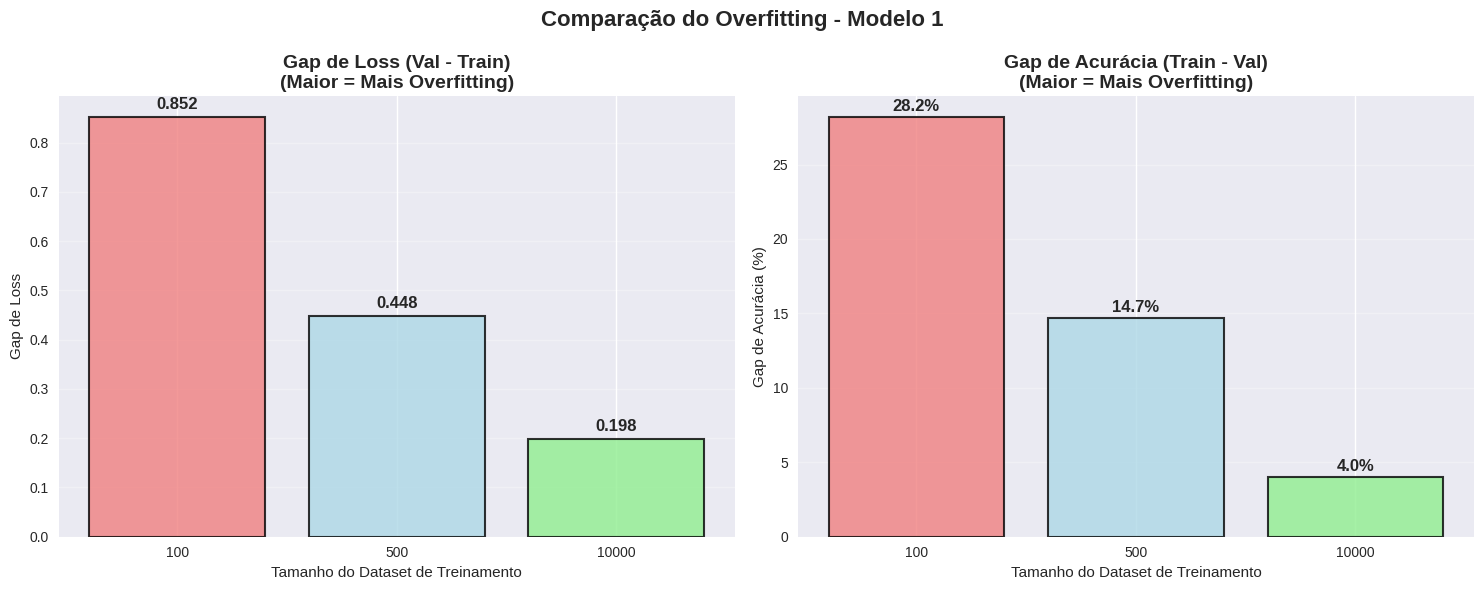

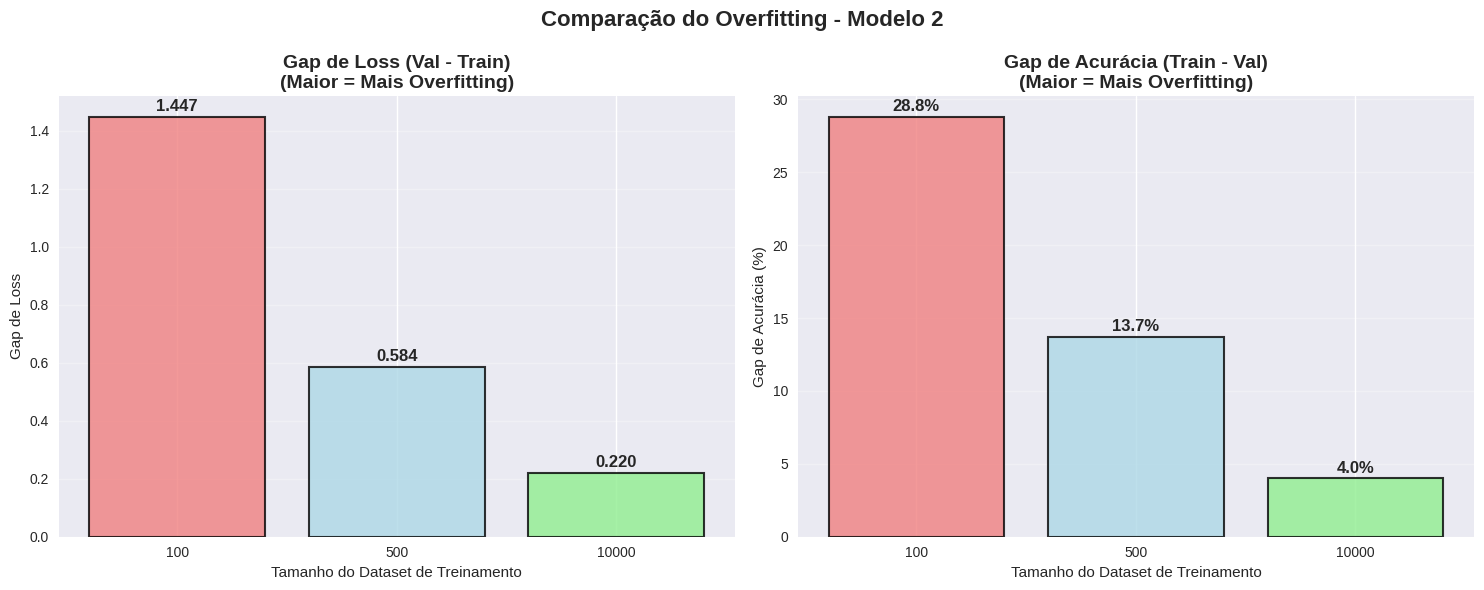

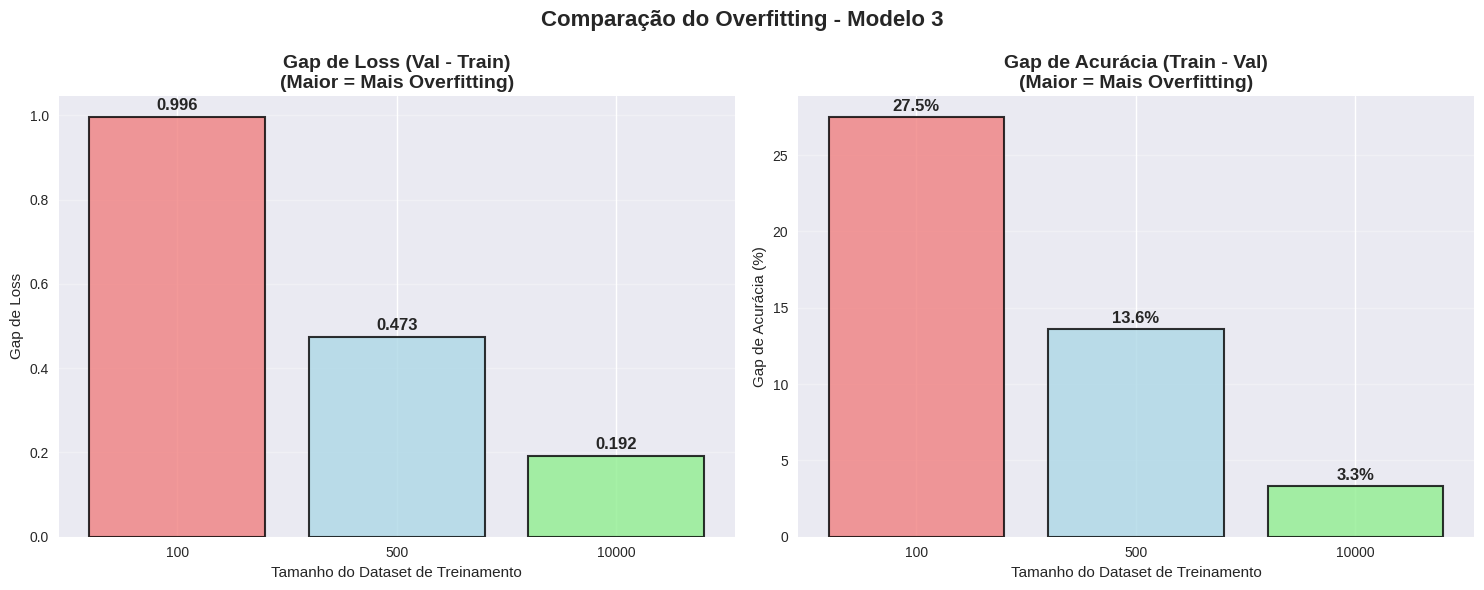

In [ ]:
for i in range(3):
  # Gráfico de barras comparativo do gap de overfitting
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

  # Extrair dados para os gráficos
  dataset_sizes_str = [str(size) for size in dataset_sizes]
  loss_gaps = []
  acc_gaps = []

  for size in dataset_sizes:
      history = models[i]["results_by_size"][size]
      loss_gap = history['val_losses'][-1] - history['train_losses'][-1]
      acc_gap = history['train_accuracies'][-1] - history['val_accuracies'][-1]
      loss_gaps.append(loss_gap)
      acc_gaps.append(acc_gap)

  # Gráfico de gap de loss
  bars1 = ax1.bar(dataset_sizes_str, loss_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                  edgecolor='black', linewidth=1.5, alpha=0.8)
  ax1.set_title('Gap de Loss (Val - Train)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
  ax1.set_xlabel('Tamanho do Dataset de Treinamento')
  ax1.set_ylabel('Gap de Loss')
  ax1.grid(True, axis='y', alpha=0.3)

  # Adicionar valores nas barras
  for bar, value in zip(bars1, loss_gaps):
      height = bar.get_height()
      ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
              f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

  # Gráfico de gap de acurácia
  bars2 = ax2.bar(dataset_sizes_str, acc_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                  edgecolor='black', linewidth=1.5, alpha=0.8)
  ax2.set_title('Gap de Acurácia (Train - Val)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
  ax2.set_xlabel('Tamanho do Dataset de Treinamento')
  ax2.set_ylabel('Gap de Acurácia (%)')
  ax2.grid(True, axis='y', alpha=0.3)

  # Adicionar valores nas barras
  for bar, value in zip(bars2, acc_gaps):
      height = bar.get_height()
      ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
              f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

  fig.suptitle(f'Comparação do Overfitting - Modelo {i+1}', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

### Análise dos gaps

Primeiramente, observa-se que o aumento do tamanho do dataset reduziu significativamente o overfitting em todos os modelos.

Além disso, nota-se que, em cada modelo, os gaps validação-treino de loss e acurácia variaram bastante com os diferentes tamanhos de dataset de treinamento. Porém, em todas as instâncias, o modelo 2 foi o que apresentou maior gap de loss, pois, embora possua menos parâmetros treináveis que o modelo 3, ele tem a arquitetura mais complexa dos 3, com 4 camadas lineares.

Por outro lado, o modelo que apresentou menor overfitting foi o modelo 1, pois era o que tinha a arquitetura mais simples dentre os 3. Esse modelo possui apenas uma camada linear com 128 neurônios, e 3 vezes menos parâmetros treináveis que o modelo 2.

Dessa forma, fica claro que é essencial balancear a complexidade de arquitetura do modelo de acordo com o problema a fim de evitar o overfitting e atingir uma performance melhor.